In [107]:
from __future__ import unicode_literals, print_function, division
import random
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import time
from torch.utils.data import DataLoader
from cn_cn_data import get_cn_en_dataset, collate_padded_fn, cn_vocab, en_vocab, en_tokenizer_


In [108]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)

In [109]:
max_length = 50
batch_size = 16

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
dataset = get_cn_en_dataset(None, device)

print('length of dataset', len(dataset))

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [23496, 2938, 2937], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_padded_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_padded_fn)

print('length of train_loader', len(train_loader))
print('length of val_loader', len(val_loader))
print('length of test_loader', len(test_loader))

length of dataset 29371
length of train_loader 1469
length of val_loader 184
length of test_loader 184


In [110]:
for i, item in enumerate(train_loader):
    print(item[0][0].shape, item[1].shape)
    print([idx[0].item() for idx in item[0][0]])
    print([idx[0].item() for idx in item[1]])

    print(item[0][1])
    break

torch.Size([14, 16]) torch.Size([13, 16])
[2, 4019, 264, 460, 325, 111, 10, 1085, 48, 78, 954, 10, 5, 3]
[2, 70, 262, 909, 516, 1466, 3242, 167, 2524, 1402, 5, 3, 1]
tensor([14, 11, 10, 10,  9,  9,  8,  8,  8,  8,  7,  7,  7,  6,  6,  5])


In [111]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, input_lengths):
        embedded = self.dropout(self.embedding(input))
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.to('cpu'))

        #packed_outputs is a packed sequence containing all hidden states, hidden is now from the final non-padded element in the batch
        packed_outputs, hidden = self.gru(packed_embedded)

        #outputs is now a non-packed sequence, all hidden states obtained, when the input is a pad token are all zeros
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden.unsqueeze(0)


In [112]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.attn = nn.Linear(hidden_size * 3, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs, mask):
        seq_len = encoder_outputs.size(1)

        hidden = hidden.permute(1, 0, 2)
        # repeat decoder hidden state src_len times, hidden = [batch, seq_len, hidden size]
        hidden = hidden.repeat(1, seq_len, 1)

        # [batch, seq_len, hidden size * 2]
        outputs_cat_hidden = torch.cat((hidden, encoder_outputs), dim=2)

        # energy = [batch, seq_len, hidden size]
        energy = torch.tanh(self.attn(outputs_cat_hidden))

        # attention= [batch, seq_len]
        attention = self.v(energy).squeeze(2)

        attention = attention.masked_fill(mask == 0, -1e10)

        return self.softmax(attention)


In [113]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.attention = Attention(hidden_size)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size * 3, hidden_size)
        self.out = nn.Linear(hidden_size * 4, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):
        # input = [batch, 1]
        # hidden = [1, batch, hidden_size]
        #mask = [batch size, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch, seq_len, hidden_size * 2]
        # embedded = [1, batch, hidden_size]
        embedded = self.dropout(self.embedding(input)).unsqueeze(0)

        # [batch, 1, seq_len]
        attention = self.attention(hidden, encoder_outputs, mask).unsqueeze(1)

        # weighted_encoder_outputs = [batch, 1, hidden_size * 2]
        weighted_encoder_outputs = torch.bmm(attention, encoder_outputs).permute(1, 0, 2) # (1, batch, hidden_size)

        # output = [seq_len, batch, hidden_size], hidden = [n_layers(1), batch, hidden_size]
        output, hidden = self.rnn(torch.cat((embedded, weighted_encoder_outputs), dim=2), hidden)

        embedded = embedded.squeeze(0) # [batch, hidden_size]
        output = output.squeeze(0) # [batch, hidden_size]
        weighted_encoder_outputs = weighted_encoder_outputs.squeeze(0) # [batch, hidden_size]

        prediction = self.out(torch.cat((output, weighted_encoder_outputs, embedded), dim=1)) # [batch, output _ize]
        return prediction, hidden, attention.squeeze(1)


In [114]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, input_pad, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.input_pad = input_pad
        self.device = device
        
        assert encoder.hidden_size == decoder.hidden_size, "Hidden dimensions of encoder and decoder must be equal!"
    
    def create_mask(self, input):
        mask = (input != self.input_pad).permute(1, 0)
        return mask
        
    def forward(self, inputs, input_lengths, target, teacher_forcing_ratio = 0.5):
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        encoder_outputs, hidden = self.encoder(inputs, input_lengths)
        mask = self.create_mask(inputs)

        batch_size = inputs.size(1)
        target_length = target.size(0)
        output_size = self.decoder.output_size

        input = inputs[0]
        outputs = torch.zeros(target_length, batch_size, output_size).to(self.device)
        for t in range(1, target_length):
            
            #insert input token embedding, previous hidden state, all encoder hidden states and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = target[t] if use_teacher_forcing else top1.detach()

        
        return outputs

In [115]:
hidden_size = 256
encoder = Encoder(cn_vocab_size, hidden_size).to(device)
decoder = Decoder(hidden_size, en_vocab_size).to(device)

model = Seq2Seq(encoder, decoder, cn_vocab['<pad>'], device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(11280, 256)
    (gru): GRU(256, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
      (softmax): Softmax(dim=1)
    )
    (embedding): Embedding(7910, 256)
    (rnn): GRU(768, 256)
    (out): Linear(in_features=1024, out_features=7910, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [116]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,926,310 trainable parameters


In [117]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = en_vocab['<pad>'])

In [118]:
def train(model, train_loader, optimizer, criterion, clip=1, plot_every=100):
    total_loss = 0
    plot_losses = []
    plot_loss_total = 0
    for iter, (input, target) in enumerate(train_loader, 1):
        inputs, input_lengths = input

        optimizer.zero_grad()

        output = model(inputs, input_lengths, target)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        target = target[1:].view(-1)

        loss = criterion(output, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()
        plot_loss_total += loss.item()

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
       
    return (total_loss / len(train_loader), plot_losses)

In [119]:
def evaluate(model, val_loader, criterion):
    total_loss = 0
    with torch.no_grad():
    
        for i, (input, target) in enumerate(val_loader):

            inputs, input_lengths = input

            output = model(inputs, input_lengths, target, 0)
            
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            target = target[1:].view(-1)

            loss = criterion(output, target)

            total_loss += loss.item()
        
    return total_loss / len(val_loader)

In [120]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [121]:
N_EPOCHS = 10
model_path = './models/seq2seq-f1.pt'
train_losses = []
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, plot_losses = train(model, train_loader, optimizer, criterion, CLIP)
    train_losses = train_losses + plot_losses
    valid_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 6m 37s
	Train Loss: 4.424 | Train PPL:  83.460
	 Val. Loss: 4.181 |  Val. PPL:  65.433
Epoch: 02 | Time: 6m 23s
	Train Loss: 3.175 | Train PPL:  23.928
	 Val. Loss: 3.637 |  Val. PPL:  37.976
Epoch: 03 | Time: 6m 31s
	Train Loss: 2.366 | Train PPL:  10.658
	 Val. Loss: 3.404 |  Val. PPL:  30.098
Epoch: 04 | Time: 6m 32s
	Train Loss: 1.786 | Train PPL:   5.964
	 Val. Loss: 3.425 |  Val. PPL:  30.710
Epoch: 05 | Time: 6m 30s
	Train Loss: 1.380 | Train PPL:   3.974
	 Val. Loss: 3.528 |  Val. PPL:  34.056
Epoch: 06 | Time: 6m 28s
	Train Loss: 1.115 | Train PPL:   3.049
	 Val. Loss: 3.660 |  Val. PPL:  38.866
Epoch: 07 | Time: 6m 31s
	Train Loss: 0.940 | Train PPL:   2.560
	 Val. Loss: 3.815 |  Val. PPL:  45.396
Epoch: 08 | Time: 6m 32s
	Train Loss: 0.807 | Train PPL:   2.242
	 Val. Loss: 3.920 |  Val. PPL:  50.379
Epoch: 09 | Time: 6m 31s
	Train Loss: 0.707 | Train PPL:   2.027
	 Val. Loss: 4.013 |  Val. PPL:  55.330
Epoch: 10 | Time: 6m 28s
	Train Loss: 0.623 | Train PPL

In [122]:
model.load_state_dict(torch.load(model_path))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.344 | Test PPL:  28.336 |


<Figure size 640x480 with 0 Axes>

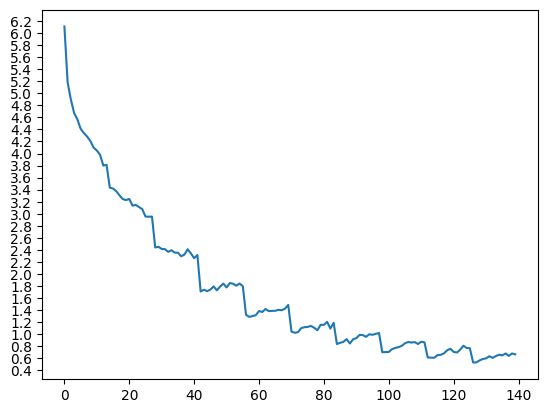

In [123]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [124]:
def translate_sentence(sentence, max_length=max_length):
    with torch.no_grad():
        inputs = dataset.tokenize_sentence(sentence, True).unsqueeze(0)
        inputs = inputs.permute(1, 0)
        input_lengths = torch.tensor([len(inputs)])

        mask = model.create_mask(inputs)
        encoder_outputs, hidden = model.encoder(inputs, input_lengths)

        input = torch.tensor([cn_vocab['<sos>']], device=device)

        words = []
        attentions = torch.zeros(max_length, input_lengths[0])

        for i in range(max_length):
            output, hidden, attention = model.decoder(input, hidden, encoder_outputs, mask)
            top1 = output.argmax(1) 
            attentions[i] = attention.squeeze().data
            if top1.item() == en_vocab['<eos>']:
                words.append('<eos>')
                break
            else:
                words.append(en_vocab.lookup_token(top1.item()))

            input = top1.detach()

        return words, attentions[:i + 1]


In [125]:
def translateRandomly(n=10):
    for i in range(n):
        pair = random.choice(dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        words, _ = translate_sentence(pair[0])
        sentence = ' '.join(words)
        print('<', sentence)
        print('')

translateRandomly()


> 我喜欢学习外语。
= I like to study foreign languages.
< I like study study foreign languages . <eos>

> 当你进入礼拜堂时，把你的帽子脱下来。
= Take your hat off when you enter a house of worship.
< Walk you when you enter a hat , your hat . <eos>

> 他是个好人。
= He's a good person.
< He is a good person . <eos>

> 我谁也不需要。
= I don't need anyone.
< I do n't need . <eos>

> 请稍等一下。
= Please hold on a moment.
< Please wait a a . <eos>

> 把眼镜戴上!
= Put on your glasses.
< Put the glasses on the . <eos>

> 让我们明天参观一些寺庙。
= Let's visit some temples tomorrow.
< Let 's take a little tomorrow . <eos>

> 他老是把我和我姐姐搞错。
= He always mistakes me for my sister.
< He always always my older sister . <eos>

> 她知道你的电话号码？
= Does she know your phone number?
< Is she know your phone number ? <eos>

> 你喜欢看电影吗？
= Do you like to watch movies?
< Do you like to the movies ? <eos>



I 'm watching television . <eos>


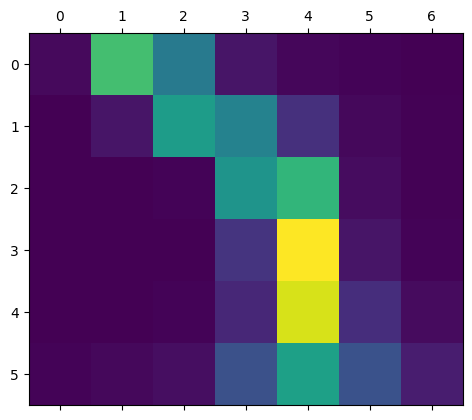

In [126]:
words, attentions = translate_sentence("我在看电视。")
sentence = ' '.join(words)
print(sentence)
plt.matshow(attentions.numpy())


In [127]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for (input, target) in data:
        pred_trget, _ = translate_sentence(input, max_len)
        target = en_tokenizer_(target)
        #cut off <eos> token
        pred_trget = pred_trget[:-1]
        
        pred_trgs.append(pred_trget)
        trgs.append([target])
        
    return bleu_score(pred_trgs, trgs)

In [128]:
def calculate_data_bleu(n_num=200):
    data = [random.choice(dataset.pairs) for i in range(n_num)]
    bleu_score = calculate_bleu(data)
    return bleu_score

bleu_score = calculate_data_bleu()


print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 31.87
